In [1]:
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import streamlit as st

In [2]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [3]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
4523,ham,I've sent Ì_ my part..,NaN,NaN,NaN
3369,ham,Most of the tiime when i don't let you hug me ...,NaN,NaN,NaN
2464,ham,They will pick up and drop in car.so no problem..,NaN,NaN,NaN
4351,ham,Hows the pain dear?y r u smiling?,NaN,NaN,NaN
4214,ham,No dear i was sleeping :-P,NaN,NaN,NaN


# Data Cleaning

In [5]:
# Keep only necessary columns
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

# Check the distribution of labels
print(df['label'].value_counts())

label
ham     4825
spam     747
Name: count, dtype: int64


In [6]:
df.sample(5)

,label,message
4337,ham,Yes when is the appt again?
2889,ham,Shuhui has bought ron's present it's a swatch ...
145,ham,Whats the staff name who is taking class for us?
38,ham,Anything lor... U decide...
3800,ham,"It's ok, at least armand's still around"


In [7]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.shape

(5572, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [10]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [11]:
df['label'] = encoder.fit_transform(df['label'])

In [12]:
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
# missing values
df.isnull().sum()

label      0
message    0
dtype: int64

In [14]:
# check for duplicate values
df.duplicated().sum()

403

In [15]:
# remove duplicates
df = df.drop_duplicates(keep='first')

In [16]:
df.duplicated().sum()

0

In [17]:
df.shape

(5169, 2)

# EDA

In [19]:
df['label'].value_counts()

label
0    4516
1     653
Name: count, dtype: int64

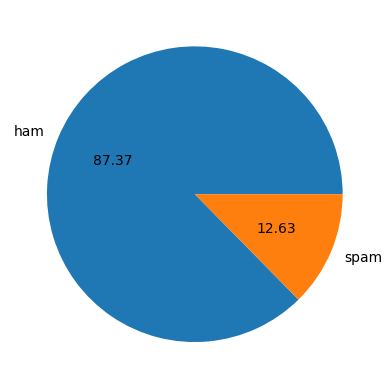

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.pie(df['label'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [21]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
df['num_characters'] = df['message'].apply(len)

In [23]:
df.head()

,label,message,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [24]:
# num of words
df['num_words'] = df['message'].apply(lambda x:len(nltk.word_tokenize(x)))

In [25]:
df.head()

,label,message,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [26]:
df['num_sentences'] = df['message'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [27]:
df.head()

,label,message,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [28]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [29]:
# ham
df[df['label'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [30]:
#spam
df[df['label'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


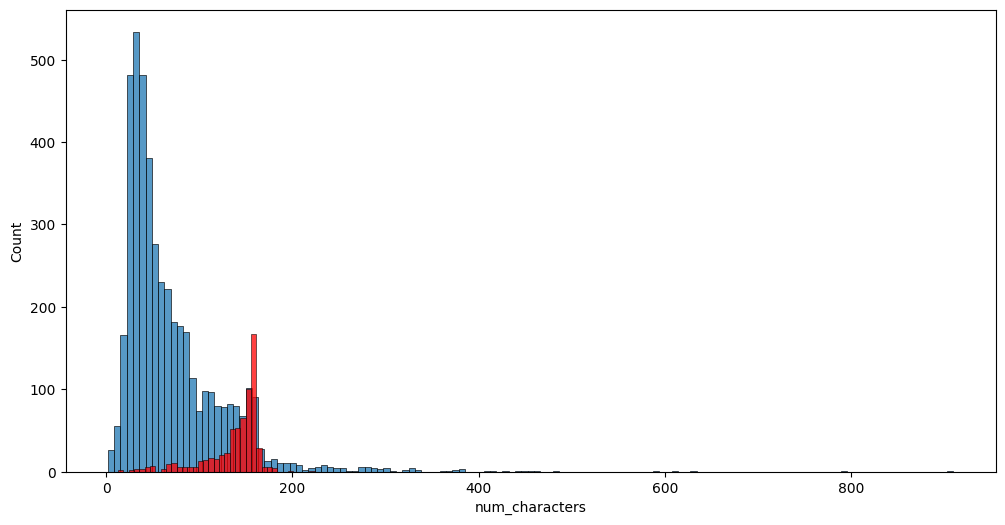

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.histplot(df[df['label'] == 0]['num_characters'])
sns.histplot(df[df['label'] == 1]['num_characters'], color='red')
plt.show()

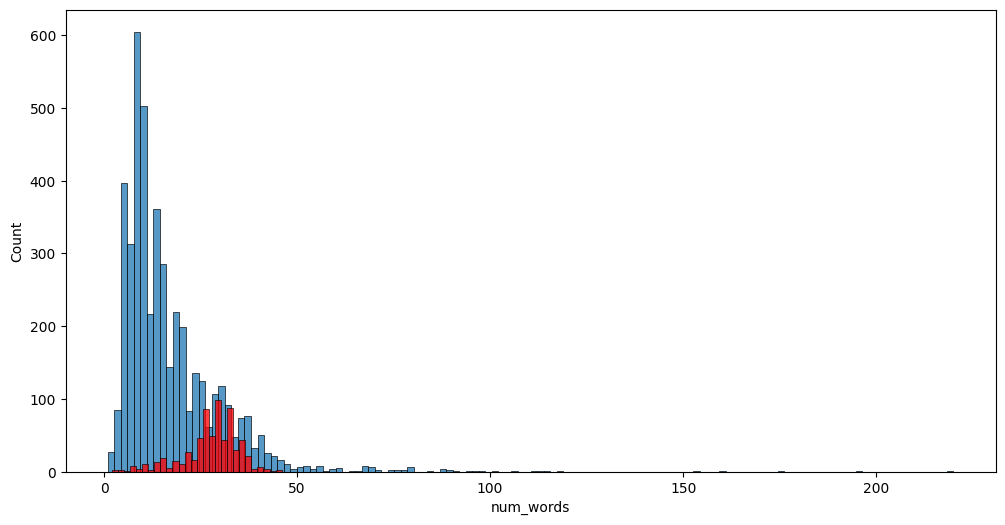

In [32]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['label'] == 0]['num_words'])
sns.histplot(df[df['label'] == 1]['num_words'],color='red')
plt.show()

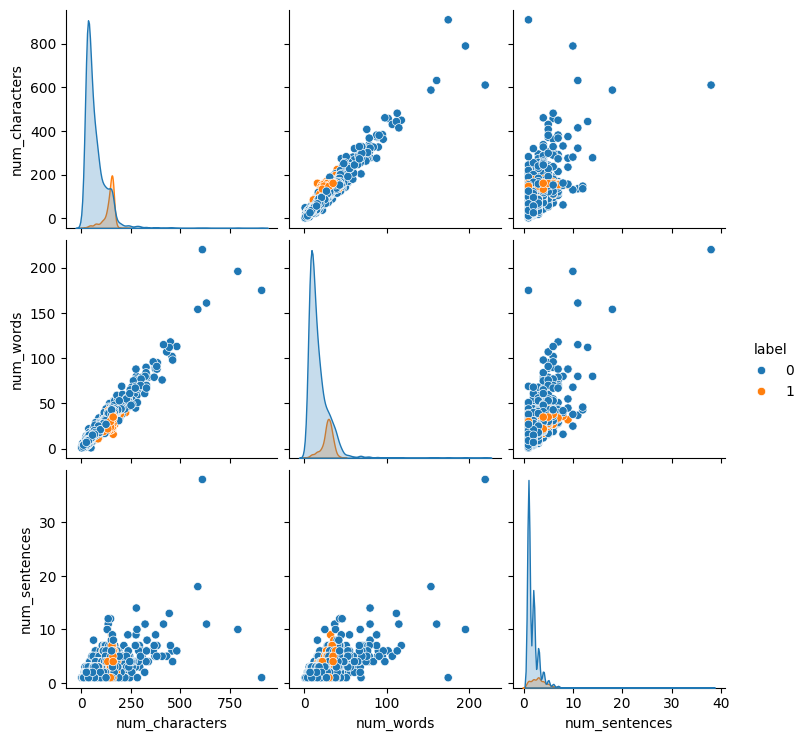

In [33]:
pairplot = sns.pairplot(df, hue='label')
plt.show()

In [34]:
pairplot.figure.savefig('pairplot.png')  # Save the plot as an image file

# Data Preprocessing
* Lower Case
* Tokenization
* removing special characters
* removing stopwords
* stemmingming

In [36]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Initialize the PorterStemmer
ps = PorterStemmer()

# Text transformation function
def transform_text(text):
    # Lowercase
    text = text.lower()
    # Tokenization
    text = nltk.word_tokenize(text)
    # Remove special characters and numbers
    text = [word for word in text if word.isalnum()]
    # Remove stopwords and punctuation
    text = [word for word in text if word not in stopwords.words('english') and word not in string.punctuation]
    # Stemming
    text = [ps.stem(word) for word in text]
    return " ".join(text)

# Apply the transformation
df['transformed_message'] = df['message'].apply(transform_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
df.head()

,label,message,num_characters,num_words,num_sentences,transformed_message
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


### Generating wordcloud for spam message

In [39]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [40]:
spam_wc = wc.generate(df[df['label'] == 1]['transformed_message'].str.cat(sep=" "))

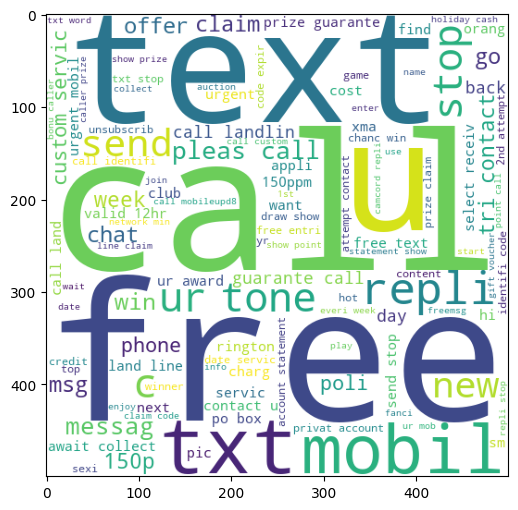

In [41]:
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)
plt.show()

In [42]:
spam_corpus = []
for msg in df[df['label'] == 1]['transformed_message'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [43]:
len(spam_corpus)

9939

In [44]:
from collections import Counter
Counter(spam_corpus).most_common(30)

[('call', 320),
 ('free', 191),
 ('2', 155),
 ('txt', 141),
 ('text', 122),
 ('u', 119),
 ('ur', 119),
 ('mobil', 114),
 ('stop', 104),
 ('repli', 103),
 ('claim', 98),
 ('4', 97),
 ('prize', 82),
 ('get', 74),
 ('new', 64),
 ('servic', 64),
 ('tone', 63),
 ('send', 60),
 ('urgent', 57),
 ('nokia', 57),
 ('contact', 56),
 ('award', 55),
 ('phone', 52),
 ('cash', 51),
 ('pleas', 51),
 ('week', 49),
 ('win', 48),
 ('c', 45),
 ('collect', 45),
 ('min', 45)]

In [45]:
pd.DataFrame(Counter(spam_corpus).most_common(30))  # added in pandas dataframe 

,0,1
0,call,320
1,free,191
2,2,155
3,txt,141
4,text,122
5,u,119
6,ur,119
7,mobil,114
8,stop,104
9,repli,103


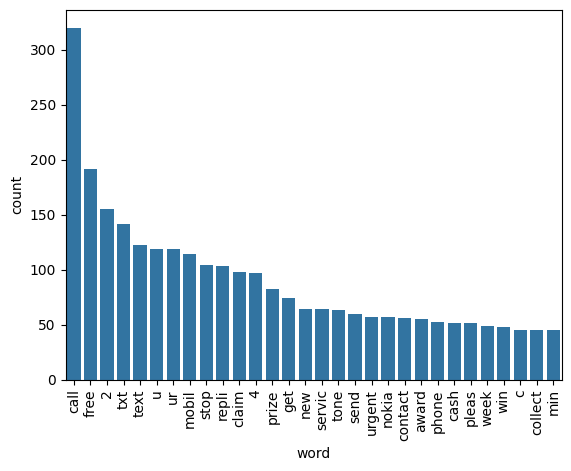

In [46]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Count the most common words in the spam_corpus
word_counts = Counter(spam_corpus).most_common(30)

# Convert to a DataFrame for easier plotting
word_counts_df = pd.DataFrame(word_counts, columns=['word', 'count'])

# Create the bar plot
sns.barplot(x='word', y='count', data=word_counts_df)

# Rotate x-axis labels for better readability
plt.xticks(rotation='vertical')

# Show the plot
plt.show()

### Generating wordcloud for not spam message

In [48]:
ham_wc = wc.generate(df[df['label'] == 0]['transformed_message'].str.cat(sep=" "))

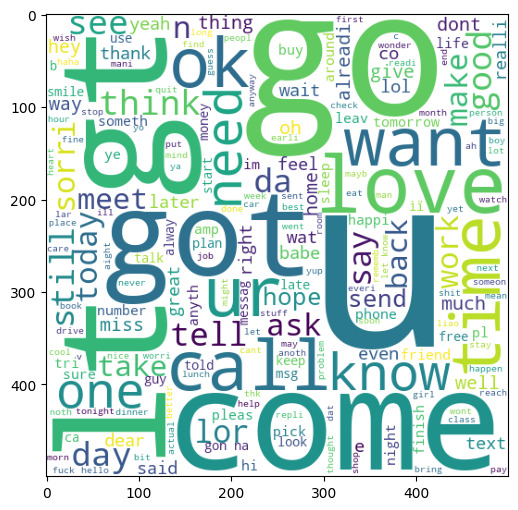

In [49]:
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)
plt.show()

In [50]:
ham_corpus = []
for msg in df[df['label'] == 0]['transformed_message'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [51]:
len(spam_corpus)

9939

In [52]:
from collections import Counter
Counter(ham_corpus).most_common(30)

[('u', 883),
 ('go', 404),
 ('get', 349),
 ('gt', 288),
 ('lt', 287),
 ('2', 284),
 ('come', 275),
 ('got', 236),
 ('know', 236),
 ('like', 234),
 ('call', 233),
 ('time', 219),
 ('ok', 217),
 ('love', 216),
 ('good', 213),
 ('want', 208),
 ('ur', 197),
 ('day', 190),
 ('need', 170),
 ('one', 165),
 ('lor', 159),
 ('4', 156),
 ('home', 152),
 ('think', 149),
 ('see', 147),
 ('take', 143),
 ('still', 143),
 ('da', 142),
 ('tell', 133),
 ('make', 129)]

In [53]:
pd.DataFrame(Counter(ham_corpus).most_common(30))

,0,1
0,u,883
1,go,404
2,get,349
3,gt,288
4,lt,287
5,2,284
6,come,275
7,got,236
8,know,236
9,like,234


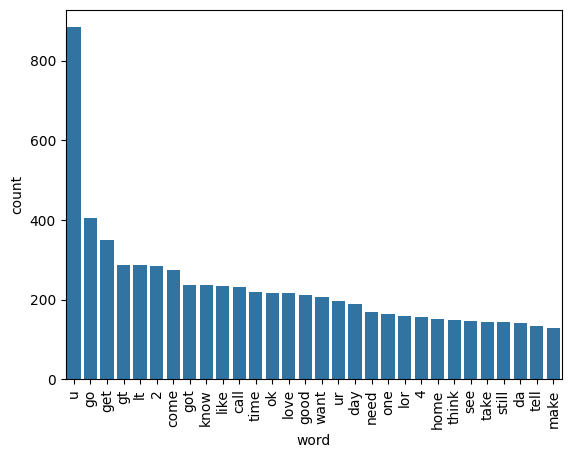

In [54]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Count the most common words in the spam_corpus
word_counts = Counter(ham_corpus).most_common(30)

# Convert to a DataFrame for easier plotting
word_counts_df = pd.DataFrame(word_counts, columns=['word', 'count'])

# Create the bar plot
sns.barplot(x='word', y='count', data=word_counts_df)

# Rotate x-axis labels for better readability
plt.xticks(rotation='vertical')

# Show the plot
plt.show()

# Model Building

In [56]:
# Vectorize the text using TF-IDF
tfidf = TfidfVectorizer(max_features=3000)
# After vectorizing the data
from imblearn.over_sampling import SMOTE

# After vectorizing the data
X = tfidf.fit_transform(df['transformed_message']).toarray()

# Encode the labels
y = pd.get_dummies(df['label'], drop_first=True).values.ravel()

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Now, split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Train the model as usual
model = MultinomialNB()
model.fit(X_train, y_train)


MultinomialNB()

In [57]:
# Predict on the test set
y_pred = model.predict(X_test)

# Display accuracy, classification report, and confusion matrix
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9739900387382402

Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.97      0.97       884
        True       0.98      0.97      0.97       923

    accuracy                           0.97      1807
   macro avg       0.97      0.97      0.97      1807
weighted avg       0.97      0.97      0.97      1807


Confusion Matrix:
 [[861  23]
 [ 24 899]]


In [58]:
# # Save the vectorizer and model using joblib
# joblib.dump(tfidf, 'vectorizer.pkl')
# joblib.dump(model, 'spam_classifier_model.pkl')